In [1]:
import os
import time  
import matplotlib.pyplot as plt
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
path = "/home/temgar.s/pneumonia_dataset/Pneumonia"

In [3]:
Image_path = os.path.join(path, "Training", "Images")
Mask_path = os.path.join(path, "Training", "Masks")

In [4]:
print("Total Images:", len(os.listdir(Image_path)))
print("Total Masks:", len(os.listdir(Mask_path)))

Total Images: 26684
Total Masks: 26684


In [5]:
Sample_Image = os.listdir(Image_path)[0]
img = Image.open(os.path.join(Image_path, Sample_Image))
Mask = Image.open(os.path.join(Mask_path, Sample_Image))

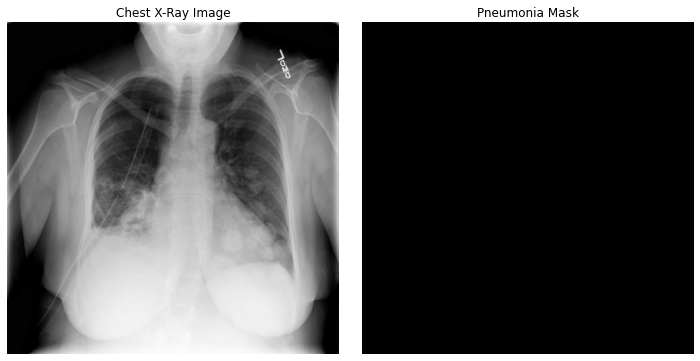

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(img, cmap='gray')
axs[0].set_title('Chest X-Ray Image')
axs[1].imshow(Mask, cmap='gray')
axs[1].set_title('Pneumonia Mask')
for ax in axs:
    ax.axis('off')
plt.tight_layout()
plt.show()

In [7]:
Image_dir = '/home/temgar.s/pneumonia_dataset/Pneumonia/Training/Images'
Mask_dir = '/home/temgar.s/pneumonia_dataset/Pneumonia/Training/Masks'

In [8]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [9]:
class PneumoniaSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_paths = sorted(os.listdir(image_dir))
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_paths[idx])
        mask_path = os.path.join(self.mask_dir, self.image_paths[idx])  

        image = Image.open(img_path).convert('L')   # grayscale
        mask = Image.open(mask_path).convert('L')   # also grayscale (single-channel)

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask


In [10]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

In [11]:
dataset = PneumoniaSegmentationDataset(Image_dir, Mask_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)

In [12]:
import matplotlib.pyplot as plt

In [13]:
images, masks = next(iter(dataloader))

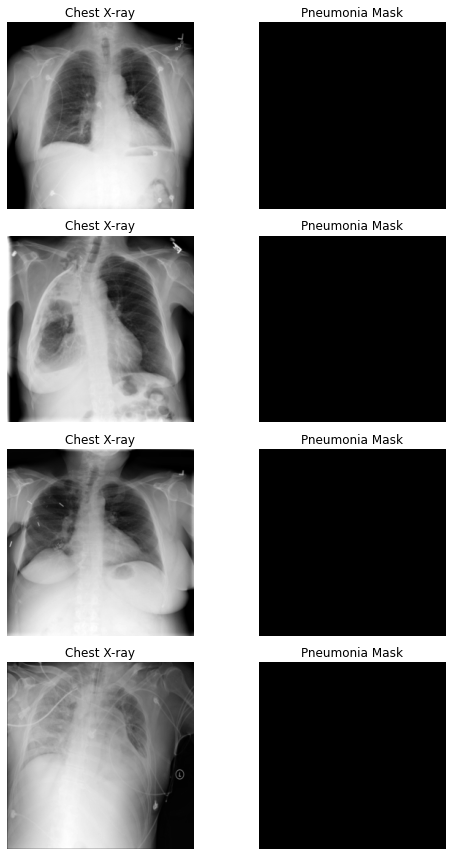

In [14]:
fig, axs = plt.subplots(4, 2, figsize=(8, 12))

for i in range(4):
    # Image
    axs[i, 0].imshow(images[i].squeeze(), cmap='gray')
    axs[i, 0].set_title("Chest X-ray")
    axs[i, 0].axis('off')

    # Mask
    axs[i, 1].imshow(masks[i].squeeze(), cmap='gray')
    axs[i, 1].set_title("Pneumonia Mask")
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()

In [15]:
import torch.nn as nn
import torch.nn.functional as F

In [16]:
class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout2d(0.25)

        self._to_linear = None
        self._get_flattened_size()

        print(f"Flattened feature size: {self._to_linear}")
        self.fc1 = nn.Linear(self._to_linear, 128)
        self.fc2 = nn.Linear(128, 2)

    def _get_flattened_size(self):
        with torch.no_grad():
            x = torch.zeros(1, 1, 256, 256)
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
            x = self.dropout1(x)
            self._to_linear = x.view(1, -1).shape[1]

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout1(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [17]:
device = torch.device("cpu")

In [18]:
model = CNNClassifier().to(device)

Flattened feature size: 131072


In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [20]:
def train_model(model, device, train_loader, optimizer, criterion, epoch):
    model.train()
    running_loss = 0.0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        
        target = (target.view(target.size(0), -1).sum(dim=1) > 0).long()

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if batch_idx % 10 == 0:
            print(f"Epoch {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}] Loss: {loss.item():.4f}")
    return running_loss / len(train_loader)


In [21]:
def evaluate(model, device, loader, criterion):
    model.eval()
    correct = 0
    total_loss = 0.0

    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            target = (target.view(target.size(0), -1).sum(dim=1) > 0).long()
            total_loss += criterion(output, target).item()
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()

    avg_loss = total_loss / len(loader)
    accuracy = correct / len(loader.dataset)
    print(f"Evaluation Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")
    return avg_loss, accuracy


Epoch 1 [0/26684] Loss: 0.6941
Epoch 1 [320/26684] Loss: 0.4956
Epoch 1 [640/26684] Loss: 0.3964
Epoch 1 [960/26684] Loss: 0.5144
Epoch 1 [1280/26684] Loss: 0.5785
Epoch 1 [1600/26684] Loss: 0.5954
Epoch 1 [1920/26684] Loss: 0.3744
Epoch 1 [2240/26684] Loss: 0.5383
Epoch 1 [2560/26684] Loss: 0.3863
Epoch 1 [2880/26684] Loss: 0.4313
Epoch 1 [3200/26684] Loss: 0.5371
Epoch 1 [3520/26684] Loss: 0.3460
Epoch 1 [3840/26684] Loss: 0.4050
Epoch 1 [4160/26684] Loss: 0.4590
Epoch 1 [4480/26684] Loss: 0.4302
Epoch 1 [4800/26684] Loss: 0.3804
Epoch 1 [5120/26684] Loss: 0.4154
Epoch 1 [5440/26684] Loss: 0.5427
Epoch 1 [5760/26684] Loss: 0.4712
Epoch 1 [6080/26684] Loss: 0.3749
Epoch 1 [6400/26684] Loss: 0.3376
Epoch 1 [6720/26684] Loss: 0.4673
Epoch 1 [7040/26684] Loss: 0.3914
Epoch 1 [7360/26684] Loss: 0.5142
Epoch 1 [7680/26684] Loss: 0.5826
Epoch 1 [8000/26684] Loss: 0.4856
Epoch 1 [8320/26684] Loss: 0.4827
Epoch 1 [8640/26684] Loss: 0.3932
Epoch 1 [8960/26684] Loss: 0.2594
Epoch 1 [9280/26684]

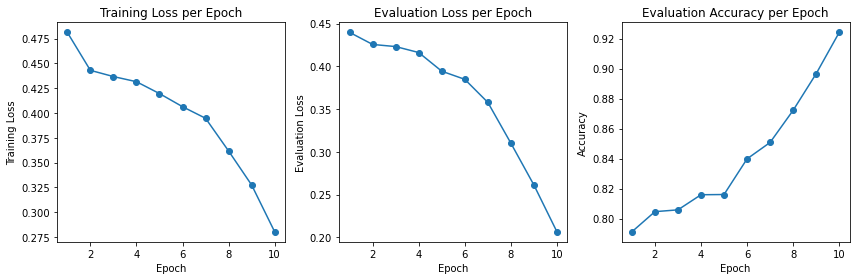

Average Epoch Time: 631.62 seconds
Overall Training Time: 8967.56 seconds


In [22]:
train_losses = []
eval_losses = []
eval_accuracies = []
epoch_times = []

n_epochs = 10

overall_start = time.time()

for epoch in range(1, n_epochs + 1):
    epoch_start = time.time()
    
    train_loss = train_model(model, device, dataloader, optimizer, criterion, epoch)
    train_losses.append(train_loss)
    epoch_time = time.time() - epoch_start
    epoch_times.append(epoch_time)
    print(f"Epoch {epoch} Training Loss: {train_loss:.4f}, Time: {epoch_time:.2f} seconds")
    
    eval_loss, eval_accuracy = evaluate(model, device, dataloader, criterion)
    eval_losses.append(eval_loss)
    eval_accuracies.append(eval_accuracy)

overall_time = time.time() - overall_start
print(f"Total Training Time: {overall_time:.2f} seconds")

import matplotlib.pyplot as plt

epochs = range(1, n_epochs + 1)
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(epochs, train_losses, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss per Epoch")

plt.subplot(1, 3, 2)
plt.plot(epochs, eval_losses, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Evaluation Loss")
plt.title("Evaluation Loss per Epoch")

plt.subplot(1, 3, 3)
plt.plot(epochs, eval_accuracies, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Evaluation Accuracy per Epoch")

plt.tight_layout()
plt.show()

print("Average Epoch Time: {:.2f} seconds".format(sum(epoch_times) / len(epoch_times)))
print("Overall Training Time: {:.2f} seconds".format(overall_time))
